In [1]:
import torch
from torch.nn import functional as F
from torch import nn
import einops
import comet_ml
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

In [2]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.set_default_dtype(torch.float32)
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

        torch.set_default_dtype(torch.float64)
    return device

device = setup_device()

print(f"Using {device} device")

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)


Using cuda device


In [3]:
full_dataset = load_dataset("Artificio/WikiArt_Full").with_format("torch")

full_dataset=full_dataset['train']


train_test_split = full_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

test_val_split = test_dataset.train_test_split(test_size=0.5)
test_dataset = test_val_split['train']
val_dataset = test_val_split['test']

In [4]:
from torchvision import models
class Encoder(nn.Module):
  @staticmethod
  def ConvBlock(in_channels:int,out_channels:int):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU(True)
    )
  def __init__(self,latent_dim:int=32768) -> None:
    super().__init__()
    self.latent_dim=latent_dim
    resnet34 = models.resnet34(pretrained=True)
    self.model = nn.Sequential(
        *list(resnet34.children())[:-2],
        nn.Conv2d(512,52,kernel_size=1,stride=1,padding=0)
        )
  def forward(self,x):
    x=self.model(x)
    return x
class Decoder(nn.Module):
  @staticmethod
  def ConvBlock(in_channels:int,out_channels:int):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
    )
  def __init__(self,latent_dim:int=32768) -> None:
    super().__init__()
    self.latent_dim=latent_dim
    self.model=nn.Sequential(
            nn.Conv2d(52,512,kernel_size=1,stride=1,padding=0),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(512,256),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(256,128),

            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(128,64),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(64,64),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64,3,kernel_size=3,stride=1,padding=1),

            nn.Sigmoid()
    )

  def forward(self,x):
    x=self.model(x)
    return x
class ArtAutoEncoder(nn.Module):

    def __init__(self):
        super(ArtAutoEncoder, self).__init__()

        self.encoder=Encoder()


        self.decoder=Decoder()
    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        return x

In [5]:
model=ArtAutoEncoder().to(device)
name="resnet34_autoencoder"
model.load_state_dict(torch.load(f"autoencoder\{name}.pth",map_location=device))
model=model.float()

c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\peter\AppData\Local\Temp\ipykernel_21172\1303292293.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickl

In [6]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
transform = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def train_vae(model, train_loader,val_loader,experiment,name="autoencoder", num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    with experiment.train():
      for epoch in range(num_epochs):
          model.train()
          train_loss=0
          i=0
          for batch in train_loader:
              i+=1
              x = batch['image'].to(device)
              x= x.float()/255.0

              x_recon = model(x)


              loss = nn.functional.mse_loss(x_recon, x, reduction='sum')


              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              experiment.log_metric(f"batch_loss_{epoch}",loss.item(),step=i)
              train_loss+=loss.item()

              if i%15==0:
                print(f"Epoch {epoch + 1}, Batches {i}, Loss: {loss.item():.4f}")
                torch.save(model.state_dict(),f"/content/drive/My Drive/{name}.pth")

          train_loss=train_loss/len(train_loader)
          print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}")
          experiment.log_metric("epoch_loss",train_loss,step=epoch)
          torch.save(model.state_dict(),f"/content/drive/My Drive/{name}.pth")

          with experiment.validate():
            model.eval()
            with torch.no_grad():
              val_loss=0
              for batch in val_loader:
                x = batch['image'].to(device)
                x=x.float()/255.0

                x_recon = model(x)

                loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
                val_loss+=loss.item()

            experiment.log_metric("val_loss",val_loss/len(val_loader),step=epoch)

def test_vae(model,test_loader,experiment):
          with experiment.test():
            model.eval()
            with torch.no_grad():
              test_loss=0
              for batch in test_loader:
                x = batch['image'].to(device)
                x=x.float()/255.0
                x_recon = model(x)
                # x=transform(x)

                loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
                test_loss+=loss.item()
            experiment.log_metric("test_loss",test_loss/len(test_loader))

batch_size = 32

enable_pin_memory = True

number_of_workers = 2 


train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory = enable_pin_memory, num_workers=number_of_workers,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory = enable_pin_memory, num_workers=number_of_workers,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory = enable_pin_memory, num_workers=number_of_workers,shuffle=True)


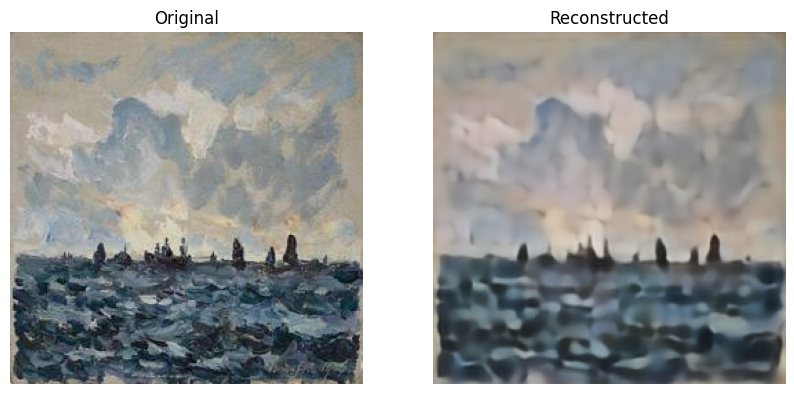

In [7]:
batch=next(iter(test_loader))
img=batch['image'][0]
model.eval()
test_img=None
with torch.no_grad():
  x = batch['image'].to(device)
  x=x.float()/255.0
  test_img = model(x)

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

axes[0].imshow(img.permute(1,2,0).numpy())
axes[0].axis('off')  
axes[0].set_title('Original')

axes[1].imshow(test_img[0].permute(1,2,0).cpu().numpy())
axes[1].axis('off')  
axes[1].set_title('Reconstructed')


plt.plot()
plt.show()

In [8]:
from picturedamagerr import PictureDamager
import os

In [9]:
masks_path = "masksnpy"
mini_MASKS = [np.load(os.path.join(masks_path, f)) for f in os.listdir(masks_path) if f.endswith(".npy")]  

In [10]:
damager = PictureDamager(mini_MASKS, 1/16)

In [11]:
def add_4th_channel(img):
    if not isinstance(img, torch.Tensor):
        img = torch.from_numpy(img).permute(2, 0, 1).float()

    C, H, W = img.shape

    mask = damager.generate_random_mask((H, W)) 
    if not isinstance(mask, torch.Tensor):
        mask = torch.from_numpy(mask).float().to(device) 

    mask = mask.unsqueeze(0)  

    img4 = torch.cat([img, mask], dim=0)
    return img4.to(device)


In [12]:
def damage_image(img4):
    rgb = img4[:3]  
    mask = img4[3]  

    mask = mask.round() 

    rgb_damaged = rgb.clone()  
    rgb_damaged[:, mask == 1] = 255 

    return rgb_damaged.to(device)

In [13]:
def show_tensor_image(img_tensor: torch.Tensor):
    """
    Wyświetla obraz z tensora PyTorch.
    img_tensor: Tensor o kształcie (C, H, W), gdzie C=3 (RGB).
    """
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  

    if img_np.max() > 1:
        img_np = img_np / 255.0

    # Wyświetl obraz
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()


In [14]:
batch=next(iter(train_dataset))
img=batch['image'].to(device)
fourthchannelimg = add_4th_channel(img)
damagedimage = damage_image(fourthchannelimg)

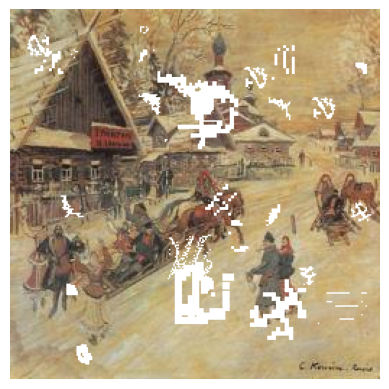

In [15]:
show_tensor_image(damagedimage)

In [16]:
latents = []
labels = []
i = 0
for batch in test_loader:
    sample = batch['image'].to(device)
    i += 1
    style = batch['style']

    for x, y in zip(sample, style):
        
        # print(x.shape)
        x = add_4th_channel(x)
        # print(x.shape)
        x = damage_image(x)
        # print(x.shape)
        x = x.float()


        with torch.inference_mode():
            b_latent = model.encoder(x.unsqueeze(0))
        b_latent = torch.flatten(b_latent.cpu())

        latents.append(b_latent.numpy())
        labels.append(y)
    print(f"batch = {i}")

batch = 1
batch = 2
batch = 3
batch = 4
batch = 5
batch = 6
batch = 7
batch = 8
batch = 9
batch = 10
batch = 11
batch = 12
batch = 13
batch = 14
batch = 15
batch = 16
batch = 17
batch = 18
batch = 19
batch = 20
batch = 21
batch = 22
batch = 23
batch = 24
batch = 25
batch = 26
batch = 27
batch = 28
batch = 29
batch = 30
batch = 31
batch = 32
batch = 33
batch = 34
batch = 35
batch = 36
batch = 37
batch = 38
batch = 39
batch = 40
batch = 41
batch = 42
batch = 43
batch = 44
batch = 45
batch = 46
batch = 47
batch = 48
batch = 49
batch = 50
batch = 51
batch = 52
batch = 53
batch = 54
batch = 55
batch = 56
batch = 57
batch = 58
batch = 59
batch = 60
batch = 61
batch = 62
batch = 63
batch = 64
batch = 65
batch = 66
batch = 67
batch = 68
batch = 69
batch = 70
batch = 71
batch = 72
batch = 73
batch = 74
batch = 75
batch = 76
batch = 77
batch = 78
batch = 79
batch = 80
batch = 81
batch = 82
batch = 83
batch = 84
batch = 85
batch = 86
batch = 87
batch = 88
batch = 89
batch = 90
batch = 91
batch = 

In [17]:
latents_train = []
labels_train = []
i = 0
for batch in train_loader:
    sample = batch['image'].to(device)
    i += 1
    style = batch['style']

    for x, y in zip(sample, style):
        

        # print(x.shape)
        x = add_4th_channel(x)
        # print(x.shape)
        x = damage_image(x)
        # print(x.shape)
        x = x.float()



        with torch.inference_mode():
            b_latent = model.encoder(x.unsqueeze(0))
        b_latent = torch.flatten(b_latent.cpu())

        latents_train.append(b_latent.numpy())
        labels_train.append(y)
    print(f"batch = {i}")

batch = 1
batch = 2
batch = 3
batch = 4
batch = 5
batch = 6
batch = 7
batch = 8
batch = 9
batch = 10
batch = 11
batch = 12
batch = 13
batch = 14
batch = 15
batch = 16
batch = 17
batch = 18
batch = 19
batch = 20
batch = 21
batch = 22
batch = 23
batch = 24
batch = 25
batch = 26
batch = 27
batch = 28
batch = 29
batch = 30
batch = 31
batch = 32
batch = 33
batch = 34
batch = 35
batch = 36
batch = 37
batch = 38
batch = 39
batch = 40
batch = 41
batch = 42
batch = 43
batch = 44
batch = 45
batch = 46
batch = 47
batch = 48
batch = 49
batch = 50
batch = 51
batch = 52
batch = 53
batch = 54
batch = 55
batch = 56
batch = 57
batch = 58
batch = 59
batch = 60
batch = 61
batch = 62
batch = 63
batch = 64
batch = 65
batch = 66
batch = 67
batch = 68
batch = 69
batch = 70
batch = 71
batch = 72
batch = 73
batch = 74
batch = 75
batch = 76
batch = 77
batch = 78
batch = 79
batch = 80
batch = 81
batch = 82
batch = 83
batch = 84
batch = 85
batch = 86
batch = 87
batch = 88
batch = 89
batch = 90
batch = 91
batch = 

In [18]:
print(len(latents))
print(len(labels))
print(len(latents_train))
print(len(labels_train))


10325
10325
82600
82600


In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
latents_concatenated = np.concatenate((np.array(latents), np.array(latents_train)))

In [21]:
labels_concatenated = np.concatenate((labels, labels_train))

In [22]:
latents_concatenated.shape

(92925, 3328)

In [23]:
import umap.umap_ as umap

In [24]:
umap_model_2d = umap.UMAP(n_components=2)
latent_2d = umap_model_2d.fit_transform(latents_concatenated)

In [25]:
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels_concatenated)

In [26]:
labels_concatenated.shape

(92925,)

Text(0.5, 1.0, 'UMAP')

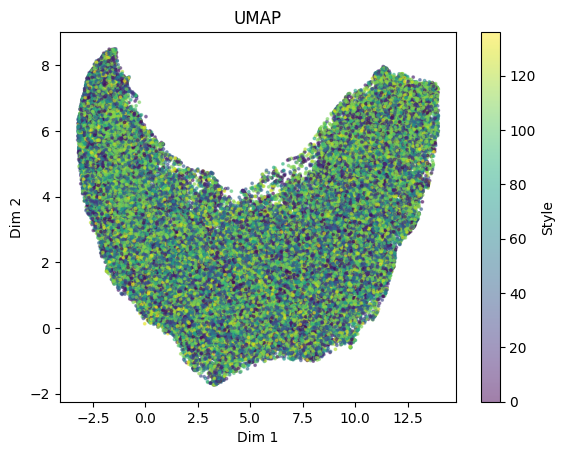

In [27]:
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=numeric_labels, alpha=.5, s=3)
plt.colorbar(scatter, label='Style')
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.title("UMAP")

In [28]:
from sklearn.cluster import KMeans


In [29]:
n_clusters = []
inertias = []

for n_cluster in range(10, 30):
    print(n_cluster)
    kmeans = KMeans(n_clusters=n_cluster).fit(latents_concatenated)
    inertia = kmeans.inertia_

    n_clusters.append(n_cluster)
    inertias.append(inertia)


10


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


11


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


12


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


13


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


15


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


16


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


17


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


18


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


19


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


20


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


21


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


22


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


23


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


24


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


25


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


26


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


27


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


28


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


29


c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Elbow Method')

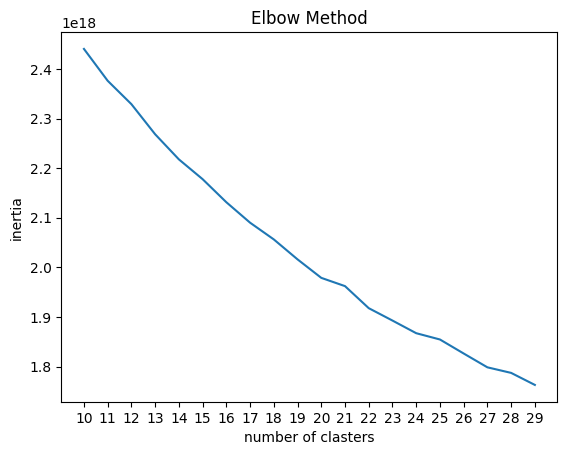

In [30]:
plt.plot(n_clusters, inertias)
plt.xticks(n_clusters)
plt.xlabel("number of clasters")
plt.ylabel("inertia")
plt.title("Elbow Method")

In [48]:
my_clusters_number: int = 20

kmeans = KMeans(n_clusters=my_clusters_number, random_state=8)
kmeans.fit(latents_concatenated)

c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=20, random_state=8)

In [49]:
import joblib

In [50]:
model_filename = f"kmeans_{my_clusters_number}_clusters.pkl"
joblib.dump(kmeans, model_filename)
print(f"Model for {my_clusters_number} clusters saved as {model_filename}")

Model for 20 clusters saved as kmeans_20_clusters.pkl


In [59]:
kmeans = joblib.load("kmeans_20_clusters.pkl")

In [103]:
reference_centroids = kmeans.cluster_centers_

In [172]:
batch = next(iter(test_loader)) 

torch.Size([32, 3, 256, 256])
(32, 3328)
[ 5 14  0  0  6 16 11  6  1 19 16 16 13 14 14  1 11 13 16  5  0  0 16 14
 16 14 14  0  5 19 11  0]
32


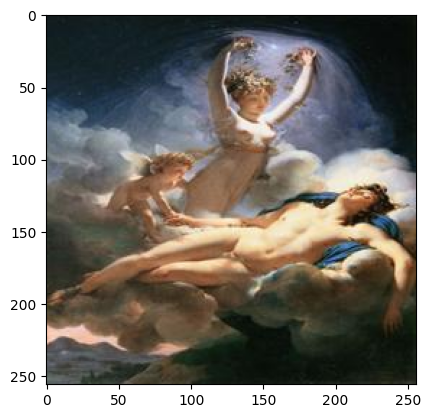

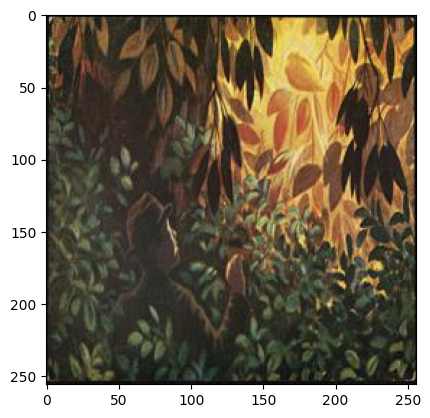

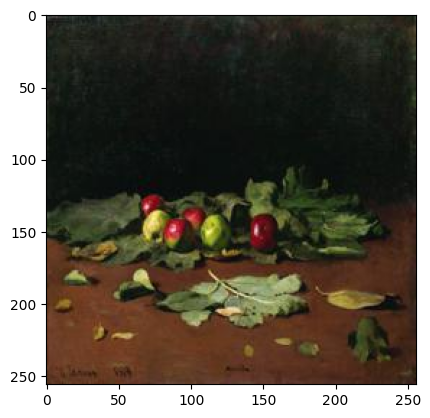

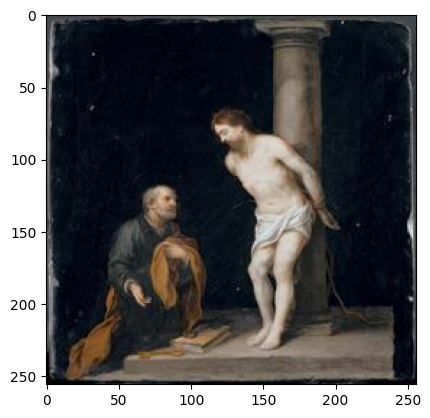

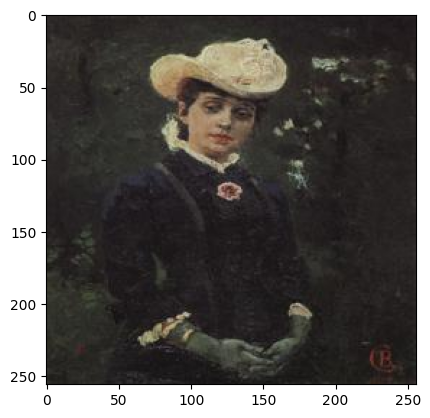

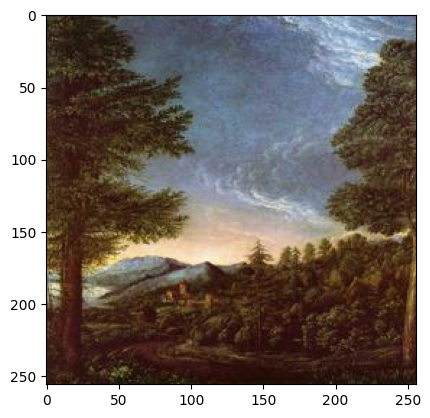

In [179]:
show_me_now_clusters_number = 14
x = batch['image'].to(device).float() 
print(x.shape)

model.eval()  
with torch.inference_mode():
    b_latent = model.encoder(x)  

b_latent = b_latent.view(b_latent.size(0), -1)  
latents = b_latent.cpu().numpy()  
print(latents.shape)

cluster_predicts = kmeans.predict(latents)  
print(cluster_predicts)
print(len(cluster_predicts))

for image, cluster_predict in zip(batch['image'], cluster_predicts):
    if cluster_predict == show_me_now_clusters_number:
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.show()
